In [1]:
import pandas as pd
import numpy as np

import os
from glob import glob

from fastai2.vision.all import *
from fastai2.metrics import error_rate
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
root_dir = './data/'
img_path = root_dir + 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/'
train_dir = img_path + 'train'
test_dir = img_path + 'test'

In [3]:
metadata = pd.read_csv(os.path.join(root_dir, 'Chest_xray_Corona_Metadata.csv'))
metadata.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
metadata.loc[metadata['Label'] == 'Pnemonia', 'Label'] = 'COVID'
metadata['Label'].unique()

array(['Normal', 'COVID'], dtype=object)

In [5]:
df_train = metadata[metadata['Dataset_type']=='TRAIN']
df_test = metadata[metadata['Dataset_type']=='TEST']

print(len(df_train))
print(len(df_test))

5286
624


In [6]:
data_glob = glob.glob('./data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/*/*')
print(len(data_glob))

full_paths = {os.path.basename(x): x for x in data_glob}
metadata['full_path'] = metadata['X_ray_image_name'].map(full_paths.get)
metadata.head()

5933


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,full_path
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN,./data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset\train\IM-0128-0001.jpeg
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN,./data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset\train\IM-0127-0001.jpeg
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN,./data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset\train\IM-0125-0001.jpeg
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN,./data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset\train\IM-0122-0001.jpeg
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN,./data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset\train\IM-0119-0001.jpeg


In [7]:
new_paths = []
for f in metadata['full_path']:
    temp = f.replace('\\', '/')
    new_paths.append(temp)

In [8]:
metadata['full_path'] = new_paths
metadata.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,full_path
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN,./data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0128-0001.jpeg
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN,./data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0127-0001.jpeg
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN,./data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0125-0001.jpeg
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN,./data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0122-0001.jpeg
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN,./data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0119-0001.jpeg


In [9]:
metadata['Dataset_type'].unique()

array(['TRAIN', 'TEST'], dtype=object)

In [10]:
df_train_val = metadata[metadata['Dataset_type']=='TRAIN']
df_test = metadata[metadata['Dataset_type']=='TEST']

In [11]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_x=ColReader(6),
                  get_y=ColReader(2),
                  splitter=RandomSplitter(valid_pct=0.12),
                  item_tfms=Resize(128),
                  batch_tfms=aug_transforms())

dsets = dblock.datasets(df_train_val)
len(dsets.valid)

634

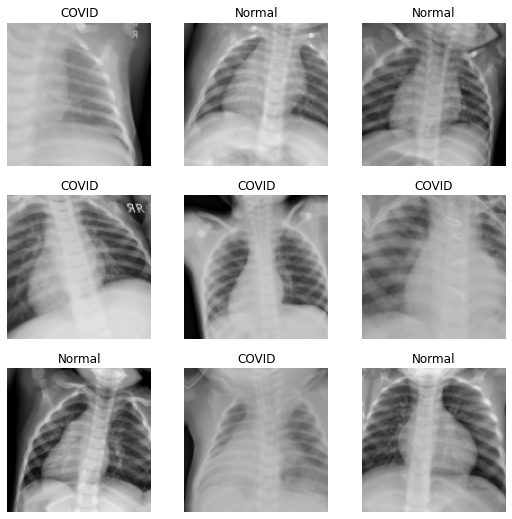

In [12]:
dls = dblock.dataloaders(metadata, bs=32, num_workers=0)
dls.show_batch()

In [13]:
transfer_base = 'vgg19'
metrics = [accuracy, Precision(), Recall(), F1Score()]

if transfer_base == 'resnet34':
    learner = cnn_learner(dls, resnet34, metrics=metrics)
elif transfer_base == 'resnet50':
    learner = cnn_learner(dls, resnet50, metrics=metrics)
elif transfer_base == 'vgg16':
    learner = cnn_learner(dls, vgg16_bn, metrics=metrics)
elif transfer_base == 'vgg19':
    learner = cnn_learner(dls, vgg19_bn, metrics=metrics)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to C:\Users\Archel/.cache\torch\hub\checkpoints\vgg19_bn-c79401a0.pth


In [14]:
# learner.lr_find()

In [15]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.435824,0.561257,0.892807,0.713675,0.948864,0.814634,01:31
1,0.252611,0.175127,0.950635,0.885246,0.920455,0.902507,01:29
2,0.179439,0.157708,0.953456,0.886486,0.931818,0.908587,01:29
3,0.176600,0.150352,0.956276,0.883598,0.948864,0.915068,01:29


Results:

1. ResNet34
- Train loss: 0.199424
- Valid loss: 0.175031
- Accuracy: 0.937941
- Precision: 0.907609	
- Recall: 0.860825
- F1 Score: 0.883598

2. ResNet50
- Train loss: 0.153900
- Valid loss: 0.106498	
- Accuracy: 0.961918
- Precision: 0.918660
- Recall: 0.950495
- F1 Score: 0.934307

3. VGG16
- Train loss: 0.180823
- Valid loss: 0.188751
- Accuracy: 0.947814
- Precision: 0.863436
- Recall: 0.970297
- F1 Score: 0.913753

4. VGG 19
- Train loss: 0.176600
- Valid loss: 0.150352
- Accuracy: 0.956276
- Precision: 0.883598
- Recall: 0.948864
- F1 Score: 0.915068

In [16]:
learner.export(fname=transfer_base+'-4epochs.pkl')

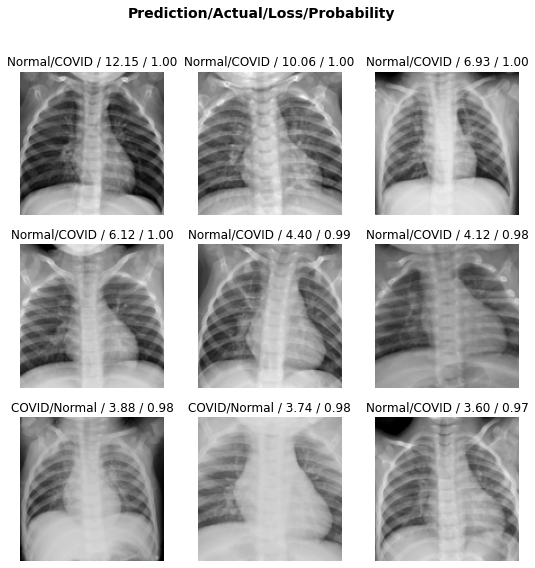

In [17]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9)

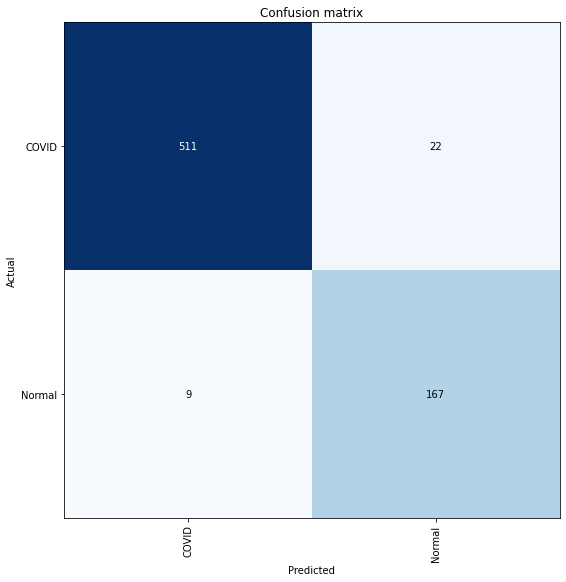

In [18]:
interp.plot_confusion_matrix(figsize=(12,8))

Results:

1. ResNet34
- TP: 498
- TN: 167
- FP: 27
- FN: 17

2. ResNet50
- TP: 490
- TN: 192
- FP: 10
- FN: 17

3. VGG16
- TP: 476
- TN: 196
- FP: 6
- FN: 31

4. VGG 19
- TP: 511
- TN: 167 
- FP: 9
- FN: 22

In [19]:
df_test.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,full_path
5286,5309,IM-0021-0001.jpeg,Normal,TEST,NaN,NaN,./data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/IM-0021-0001.jpeg
5287,5310,IM-0019-0001.jpeg,Normal,TEST,NaN,NaN,./data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/IM-0019-0001.jpeg
5288,5311,IM-0017-0001.jpeg,Normal,TEST,NaN,NaN,./data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/IM-0017-0001.jpeg
5289,5312,IM-0016-0001.jpeg,Normal,TEST,NaN,NaN,./data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/IM-0016-0001.jpeg
5290,5313,IM-0015-0001.jpeg,Normal,TEST,NaN,NaN,./data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/IM-0015-0001.jpeg


In [20]:
test_path = get_image_files(Path(test_dir))
test_path[0]

Path('data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/IM-0001-0001.jpeg')

In [21]:
test_preds = []
for t in test_path:
    pred = learner.predict(t)
    test_preds.append(pred[0])

In [22]:
test_acc = 0.0
tp = 0
tn = 0
fp = 0
fn = 0

labels = df_test['Label'].values
for i in range(len(labels)):
    if labels[i] == test_preds[i]:
        test_acc += 1
    if labels[i] == 'Normal' and test_preds[i] == 'Normal':
        tp += 1
    if labels[i] == 'Normal' and test_preds[i] == 'COVID':
        fp += 1
    if labels[i] == 'COVID' and test_preds[i] == 'Normal':
        fn += 1
    if labels[i] == 'COVID' and test_preds[i] == 'COVID':
        tn += 1

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = (2*precision*recall)/(precision+recall)

print('True Positive:', tp)
print('True Negative:', tn)
print('False Positive:', fp)
print('False Negative:', fn)
print()
print('Test accuracy:', test_acc/len(labels))
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1 Score:', f1_score)

True Positive: 179
True Negative: 383
False Positive: 55
False Negative: 7

Test accuracy: 0.9006410256410257
Test Precision: 0.7649572649572649
Test Recall: 0.9623655913978495
Test F1 Score: 0.8523809523809524


Results:

1. ResNet34
- True Positive: 164
- True Negative: 386
- False Positive: 70
- False Negative: 4

- Test accuracy: 0.8814102564102564
- Test Precision: 0.7008547008547008
- Test Recall: 0.9761904761904762
- Test F1 Score: 0.8159203980099503

2. ResNet50
- True Positive: 178
- True Negative: 386
- False Positive: 56
- False Negative: 4

- Test accuracy: 0.9038461538461539
- Test Precision: 0.7606837606837606
- Test Recall: 0.978021978021978
- Test F1 Score: 0.8557692307692306

3. VGG16
- True Positive: 190
- True Negative: 383
- False Positive: 44
- False Negative: 7

- Test accuracy: 0.9182692307692307
- Test Precision: 0.811965811965812
- Test Recall: 0.9644670050761421
- Test F1 Score: 0.8816705336426914

4. VGG 19
- True Positive: 179
- True Negative: 383
- False Positive: 55
- False Negative: 7
 
- Test accuracy: 0.9006410256410257
- Test Precision: 0.7649572649572649
- Test Recall: 0.9623655913978495
- Test F1 Score: 0.8523809523809524